# Analyzing clusters of RefSeq, known_knowns, and known_unknowns

Contigs that have at least 50% sequence identity were clustered using MMSeq2. This notebook further analyzed the results to find trends related to size of clusters, lengths of sequences in cluster, taxonomy, etc.

In [247]:
# importing pandas for table manipulations and seaborn for plotting
import pandas as pd
import seaborn as sns

### 1 MMseq2
MMseq2 clusters were generated using:

```
$
```

Commas were removed from the sequence names

```
$sed 's/,/_/g' tests/data/finaloutDB3.tsv > tests/data/finaloutDB3_nocomma.tsv

```


In [249]:
cl_table = pd.read_csv("tests/data/finaloutDB3_nocomma.tsv", sep="\t", header=None)
cl_table.head()

,0,1
0,NC_003729.1_Rice_black_streaked_dwarf_virus_se...,NC_003729.1_Rice_black_streaked_dwarf_virus_se...
1,NC_034491.1_Nyando_virus_strain_MP401_segment_...,NC_034491.1_Nyando_virus_strain_MP401_segment_...
2,NC_003654.1_Nilaparvata_lugens_reovirus_segmen...,NC_003654.1_Nilaparvata_lugens_reovirus_segmen...
3,NC_038718.1_Lukuni_virus_strain_TRVL_10076_pol...,NC_038718.1_Lukuni_virus_strain_TRVL_10076_pol...
4,NC_014509.2_Velvet_tobacco_mottle_virus__compl...,NC_014509.2_Velvet_tobacco_mottle_virus__compl...


Number of clusters detected using mmseq2 for 23,377 (`testset1_refseq_nospace.fasta`) sequences (RefSeq viruses and > 50% identity) = 12,355

In [253]:
# group by the reference cluster name and then converting its members to a list
gp_table = cl_table.groupby(0)[1].apply(list)
all_cl_table = pd.DataFrame(gp_table)
all_cl_table.shape
all_cl_table.head()


,1
0,
AC_000001.1_Ovine_adenovirus_A__complete_genome,[AC_000001.1_Ovine_adenovirus_A__complete_geno...
AC_000003.1_Canine_adenovirus_1__complete_genome,[AC_000003.1_Canine_adenovirus_1__complete_gen...
AC_000008.1_Human_adenovirus_5__complete_genome,[AC_000008.1_Human_adenovirus_5__complete_geno...
AC_000009.1_Porcine_adenovirus_C__complete_genome,[AC_000009.1_Porcine_adenovirus_C__complete_ge...
AC_000012.1_Murine_adenovirus_A__complete_genome,[AC_000012.1_Murine_adenovirus_A__complete_gen...


In [254]:
# from list to rows
all_cl_df = pd.DataFrame(all_cl_table[1].apply(pd.Series).stack())
all_cl_df.columns = ["members"]
all_cl_df.tail(5)

members
0                                                                               
known_unknowns_Contig_9_52.291:1.6995 77  _SRR7524174_Contig_3779_9.57819:1.1139
                                      78  _SRR3132466_Contig_1625_4.66607:1.1137
                                      79   _SRR7524166_Contig_1484_13.127:1.1075
                                      80   _SRR3131807_Contig_108_4.53792:1.1009
                                      81    _SRR918083_Contig_219_105.237:1.1239

In [255]:
# Distribution of cluster size
cl_size = pd.DataFrame(all_cl_df.groupby(0).apply(len))
cl_size.columns = ["size"]
cl_size.head()


,size
0,
AC_000001.1_Ovine_adenovirus_A__complete_genome,2
AC_000003.1_Canine_adenovirus_1__complete_genome,2
AC_000008.1_Human_adenovirus_5__complete_genome,4
AC_000009.1_Porcine_adenovirus_C__complete_genome,2
AC_000012.1_Murine_adenovirus_A__complete_genome,2


[Text(0,0.5,'proportion of clusters'), Text(0.5,0,'Cluster sizes')]

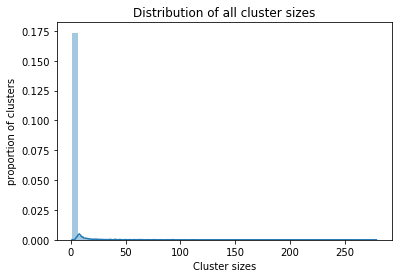

In [259]:
dp = sns.distplot(cl_size['size'].tolist())
dp.set_title('Distribution of all cluster sizes')
dp.set(xlabel='Cluster sizes', ylabel='proportion of clusters')

100

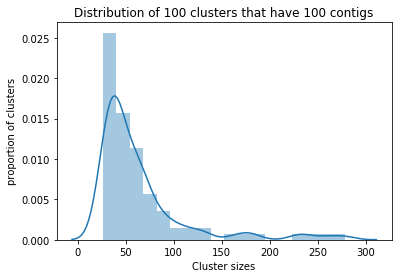

In [265]:
dp = sns.distplot(cl_size[cl_size['size'] > 25]['size'].tolist())
dp.set_title('Distribution of 100 clusters that have 100 contigs')
dp.set(xlabel='Cluster sizes', ylabel='proportion of clusters')
len(cl_size[cl_size['size'] > 25]['size'].tolist())

12251

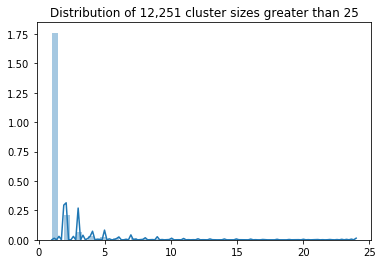

In [264]:
dp = sns.distplot(cl_size[cl_size['size'] < 25]['size'].tolist())
dp.set_title('Distribution of 12,251 cluster sizes less than 25 contigs')
len(cl_size[cl_size['size'] < 25]['size'].tolist())

In [109]:
# read in fai file generated using samtools to get sequence length of each sequence
len_table = pd.read_csv("tests/data/testset1_refseq_nospace_nocomma.fasta.fai",
                        sep="\t", header=None, index_col=0, names=["length", "A", "B", "C"])
len_table = len_table.drop(columns=["A", "B", "C"])
len_table.head()

,length
known_unknowns_Contig_1456_15.8992:1.1171,1171
known_unknowns_Contig_3410_16.1664:1.1252,1252
known_unknowns_Contig_202_5.64787:1.1102,1102
known_unknowns_Contig_13078_7.69086:1.1990,1990
known_unknowns_Contig_47579_6.28328:1.2724,2724


In [110]:
# convert length table to dictionary object
len_dict=len_table.to_dict()

In [128]:
# replace name with length of contigs in each cluster
length_info = all_cl_df.replace(len_dict['length'])

length_info.head()

members
0                                                         
AC_000001.1_Ovine_adenovirus_A__complete_genome  0   33034
                                                 1   33034
AC_000003.1_Canine_adenovirus_1__complete_genome 0   30536
                                                 1   30536
AC_000004.1_Duck_adenovirus_A__complete_genome   0   33213

In [164]:
#len_only = length_info[length_info.members.apply(lambda x: x.isint())]
#len_only.head()
#df[~df.Word.str.startswith('Y')]
#length_info.members.tolist()
len_only = length_info.convert_objects(convert_numeric=True).dropna()
len_only.head()
#length_info.members.apply(lambda x: isnumeric(x))


/Users/migunshakya/miniconda3/envs/mash/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """


members
0                                                          
AC_000001.1_Ovine_adenovirus_A__complete_genome  0  33034.0
                                                 1  33034.0
AC_000003.1_Canine_adenovirus_1__complete_genome 0  30536.0
                                                 1  30536.0
AC_000004.1_Duck_adenovirus_A__complete_genome   0  33213.0

In [166]:
length_info_reset = len_only.reset_index()
length_info_final = length_info_reset.drop(["level_1"], axis=1)
length_info_final.head()



,0,members
0,AC_000001.1_Ovine_adenovirus_A__complete_genome,33034.0
1,AC_000001.1_Ovine_adenovirus_A__complete_genome,33034.0
2,AC_000003.1_Canine_adenovirus_1__complete_genome,30536.0
3,AC_000003.1_Canine_adenovirus_1__complete_genome,30536.0
4,AC_000004.1_Duck_adenovirus_A__complete_genome,33213.0


In [172]:


len_std = pd.DataFrame(length_info_final.groupby(0)["members"].std().dropna())
#len_std[len-std['']]
len_std[len_std['members'] > 0].head()




,members
0,
NC_000870.1_Tomato_yellow_leaf_curl_Thailand_virus_DNA_B__complete_sequence,10.606602
NC_001344.1_Duck_hepatitis_B_virus__complete_genome,2.121320
NC_001367.1_Tobacco_mosaic_virus__complete_genome,5.761944
NC_001401.2_Adeno-associated_virus_-_2__complete_genome,44.034078
NC_001438.1_Bean_golden_yellow_mosaic_virus_DNA_B__complete_sequence,16.263456


Text(0.5,1,'Distribution of SD of lengths within each cluster for 52')

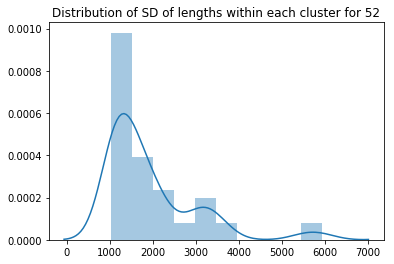

In [184]:
dx = sns.distplot(len_std[len_std['members'] > 1000]['members'].tolist())
dx.set_title("Distribution of SD of lengths within each cluster for %s" % (len(len_std[len_std['members'] > 1000]['members'])))
#len_std[len_std['members'] > 1000]['members']

In [219]:
singletons = all_cl_df.groupby(0).filter(lambda x:len(x["members"].tolist()) == 1)
singletons.head(10)
singletons.tail(10)


,,members
0,,
known_unknowns_Contig_985_28.4477:1.5285,0,known_unknowns_Contig_985_28.4477:1.5285
known_unknowns_Contig_986_7.45392:1.1626,0,known_unknowns_Contig_986_7.45392:1.1626
known_unknowns_Contig_989_25.4011:1.2229,0,known_unknowns_Contig_989_25.4011:1.2229
known_unknowns_Contig_98_86.4241:1.1364,0,known_unknowns_Contig_98_86.4241:1.1364
known_unknowns_Contig_9922_10.2301:1.3505,0,known_unknowns_Contig_9922_10.2301:1.3505
known_unknowns_Contig_9928_36.8387:1.2419,0,known_unknowns_Contig_9928_36.8387:1.2419
known_unknowns_Contig_9943_38.6203:1.3128,0,known_unknowns_Contig_9943_38.6203:1.3128
known_unknowns_Contig_9958_19.0621:1.1083,0,known_unknowns_Contig_9958_19.0621:1.1083
known_unknowns_Contig_9998_8.7882:1.1512,0,known_unknowns_Contig_9998_8.7882:1.1512


In [226]:
non_singletons = all_cl_df.groupby(0).filter(lambda x:len(x["members"].tolist()) > 1)
non_singletons.head(10)
non_singletons.tail(10)
len(set(non_singletons.reset_index()[0].tolist()))

2469

In [244]:
#NC_genomes = singletons.groupby(0).filter(lambda x: 'NC_' in ''.join(x['members'].tolist()))[0]["members"].tolist()
NC_genomes=singletons.groupby(0).filter(lambda x: 'NC_' in ''.join(x['members'].tolist())).reset_index()[0].tolist()
NC_genom = [x[:-2] for x in NC_genomes]
len(set(NC_genom))

8659

In [245]:

NC_genomes=non_singletons.groupby(0).filter(lambda x: 'NC_' in ''.join(x['members'].tolist())).reset_index()[0].tolist()
NC_genom = [x[:-2] for x in NC_genomes]
len(set(NC_genom))

741

|Title|numbers|
| ------------------------- | ------ |
| # of clusters             | 18,131 |
| # of singleton clusters   | 15,662 |
| # of non-singleton clusters  | 2,469 |
| # of singleton refseq-clusters  | 8,659 |
| # of non-singleton that have refseq-clusters  | 741 |
